In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [4]:
edu = pd.read_csv('/Users/Vi/Documents/qbus6860/group/Education-services-au-export.csv',na_values=['np','unknown'])
reviews = pd.read_csv('/Users/Vi/Documents/qbus6860/group/edu_services_google_reviews.csv',na_values=['np','unknown'])

In [5]:
edu.head()

ServiceApprovalNumber Provider Approval Number  \
0           SE-00000002              PR-00000898   
1           SE-00000003              PR-40029099   
2           SE-00000004              PR-00000898   
3           SE-00000005              PR-40002184   
4           SE-00000006              PR-40029104   

                                         ServiceName  \
0    Community Kids Waterford Early Education Centre   
1                  KIDVENTURE EARLY LEARNING EAGLEBY   
2                 Community Kids - Broadbeach Waters   
3  Little Scholars School of Early Learning Burle...   
4                     Small World Child Care Centre    

                                   ProviderLegalName        ServiceType  \
0                               G8 Education Limited  Centre-Based Care   
1  Table Mountain Trading Pty Ltd As The Trustee ...  Centre-Based Care   
2                               G8 Education Limited  Centre-Based Care   
3                         The Scholars Group Pty Ltd  Centre-Based Care   
4  A. & K. Massouras Pty. Ltd. ATF The A Massoura...  Centre-Based Care   

       ServiceAddress             Suburb State  Postcode         Phone  ...  \
0      8-10 Allora St     WATERFORD WEST   QLD    4133.0    0732009852  ...   
1       82 Fryar Road            EAGLEBY   QLD    4207.0    0738073222  ...   
2     4 Fremar Street  BROADBEACH WATERS   QLD    4217.0    0755920306  ...   
3   143 Christine Ave    BURLEIGH WATERS   QLD    4220.0    0755353288  ...   
4  113-115 Pappas Way            CARRARA   QLD    4211.0  07 5594 1844  ...   

  Holiday Care Wednesday End Time Holiday Care Thursday Start Time  \
0                           18:15                            06:15   
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   

   Holiday Care Thursday End Time Holiday Care Friday Start Time  \
0                           18:15                          06:15   
1                             NaN                            NaN   
2                             NaN                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   

  Holiday Care Friday End Time Holiday Care Saturday Start Time  \
0                        18:15                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                          NaN                              NaN   

  Holiday Care Saturday End Time Holiday Care Sunday Start Time  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

  Holiday Care Sunday End Time Temporarily Closed  
0                          NaN                 No  
1                          NaN                 No  
2                          NaN                 No  
3                          NaN                 No  
4                          NaN                 No  

[5 rows x 97 columns]

In [6]:
reviews.head()

ServiceName           TitleShownOnGoogleMaps  \
0  Chrysalis Early Learning Centre  Chrysalis Early Learning Centre   
1  Chrysalis Early Learning Centre  Chrysalis Early Learning Centre   
2  Chrysalis Early Learning Centre  Chrysalis Early Learning Centre   
3  Chrysalis Early Learning Centre  Chrysalis Early Learning Centre   
4  Chrysalis Early Learning Centre  Chrysalis Early Learning Centre   

   overall_rating  5 stars  4 stars  3 stars  2 stars  1 stars  \
0             4.8     58.0      3.0      0.0      0.0      3.0   
1             4.8     58.0      3.0      0.0      0.0      3.0   
2             4.8     58.0      3.0      0.0      0.0      3.0   
3             4.8     58.0      3.0      0.0      0.0      3.0   
4             4.8     58.0      3.0      0.0      0.0      3.0   

  individual_rating                                individual_comments  
0           5 stars  Sending our daughter to Chrysalis was the best...  
1           5 stars  Chrysalis is an incredible daycare centre for ...  
2           5 stars  My child loves attending Chrysalis, often not ...  
3           5 stars  I have had the pleasure of all 3 of my kids at...  
4           5 stars  Our daughter has absolutely thrived during her...

In [7]:
edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17663 entries, 0 to 17662
Data columns (total 97 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ServiceApprovalNumber                             17663 non-null  object 
 1   Provider Approval Number                          17663 non-null  object 
 2   ServiceName                                       17663 non-null  object 
 3   ProviderLegalName                                 17556 non-null  object 
 4   ServiceType                                       17663 non-null  object 
 5   ServiceAddress                                    17653 non-null  object 
 6   Suburb                                            17653 non-null  object 
 7   State                                             17653 non-null  object 
 8   Postcode                                          17653 non-null  float64
 9   Phone            

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29427 entries, 0 to 29426
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             29427 non-null  object 
 1   TitleShownOnGoogleMaps  29427 non-null  object 
 2   overall_rating          29427 non-null  float64
 3   5 stars                 29248 non-null  float64
 4   4 stars                 29248 non-null  float64
 5   3 stars                 29248 non-null  float64
 6   2 stars                 29248 non-null  float64
 7   1 stars                 29248 non-null  float64
 8   individual_rating       29427 non-null  object 
 9   individual_comments     23321 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.2+ MB


In [9]:
edu_subset = edu[[
    'ServiceName',
    'OverallRating',
    'ServiceType',
    'Suburb',
    'State',
    'NumberOfApprovedPlaces'
]]

df = reviews.rename(columns={
        'individual_comments': 'comments'
    }).merge(
    edu_subset,
    left_on='ServiceName',
    right_on='ServiceName',
    how='left'
)

df = df[[
    'ServiceName',
    'comments',
    'TitleShownOnGoogleMaps',
    'overall_rating',
    'OverallRating',
    'ServiceType',
    'Suburb',
    'State',
    'NumberOfApprovedPlaces'
]]
df['overall_rating']=pd.to_numeric(df['overall_rating'],errors = 'coerce')
df['NumberOfApprovedPlaces'] = pd.to_numeric(df['NumberOfApprovedPlaces'],errors = 'coerce')
df['comments']=df['comments'].astype(str)



df.dropna(subset=['comments'], inplace=True)


df.head()

ServiceName  \
0  Chrysalis Early Learning Centre   
1  Chrysalis Early Learning Centre   
2  Chrysalis Early Learning Centre   
3  Chrysalis Early Learning Centre   
4  Chrysalis Early Learning Centre   

                                            comments  \
0  Sending our daughter to Chrysalis was the best...   
1  Chrysalis is an incredible daycare centre for ...   
2  My child loves attending Chrysalis, often not ...   
3  I have had the pleasure of all 3 of my kids at...   
4  Our daughter has absolutely thrived during her...   

            TitleShownOnGoogleMaps  overall_rating  OverallRating  \
0  Chrysalis Early Learning Centre             4.8  Exceeding NQS   
1  Chrysalis Early Learning Centre             4.8  Exceeding NQS   
2  Chrysalis Early Learning Centre             4.8  Exceeding NQS   
3  Chrysalis Early Learning Centre             4.8  Exceeding NQS   
4  Chrysalis Early Learning Centre             4.8  Exceeding NQS   

         ServiceType     Suburb State  NumberOfApprovedPlaces  
0  Centre-Based Care  BUNDABERG   QLD                   100.0  
1  Centre-Based Care  BUNDABERG   QLD                   100.0  
2  Centre-Based Care  BUNDABERG   QLD                   100.0  
3  Centre-Based Care  BUNDABERG   QLD                   100.0  
4  Centre-Based Care  BUNDABERG   QLD                   100.0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30057 entries, 0 to 30056
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             30057 non-null  object 
 1   comments                30057 non-null  object 
 2   TitleShownOnGoogleMaps  30057 non-null  object 
 3   overall_rating          30057 non-null  float64
 4   OverallRating           28166 non-null  object 
 5   ServiceType             30057 non-null  object 
 6   Suburb                  30057 non-null  object 
 7   State                   30057 non-null  object 
 8   NumberOfApprovedPlaces  29771 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.1+ MB


In [11]:
count = (
    df['comments']
    .dropna()                            
    .loc[lambda s: s.str.strip() != '']  
    .shape[0]
)
print(count)

30057


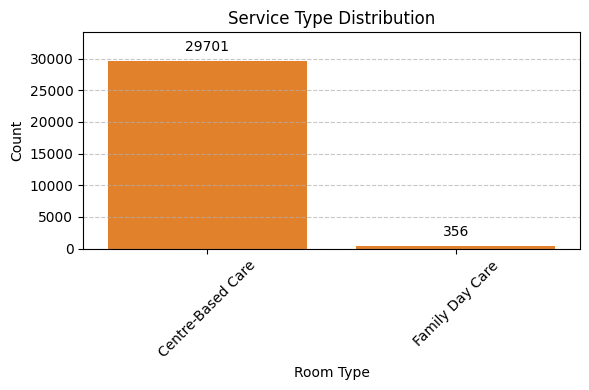

In [12]:
plt.figure(figsize=(6, 4))
order = df['ServiceType'].value_counts().index
ax = sns.countplot(data=df, x='ServiceType', order=order)
max_count = df['ServiceType'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5)
sns.countplot(data=df, x='ServiceType', order=df['ServiceType'].value_counts().index)
plt.title("Service Type Distribution")
plt.ylabel("Count")
plt.xlabel("Room Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

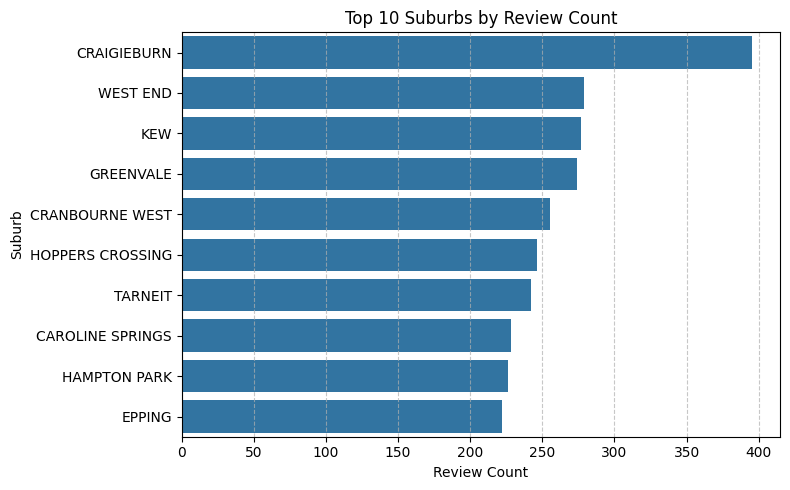

In [13]:
plt.figure(figsize=(8, 5))
top_sub = df['Suburb'].value_counts().nlargest(10)
sns.barplot(x=top_sub.values, y=top_sub.index)
plt.title("Top 10 Suburbs by Review Count")
plt.xlabel("Review Count")
plt.ylabel("Suburb")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4],
 [Text(0, 0, 'KEW'),
  Text(1, 0, 'CRANBOURNE WEST'),
  Text(2, 0, 'CRAIGIEBURN'),
  Text(3, 0, 'GREENVALE'),
  Text(4, 0, 'WEST END')])

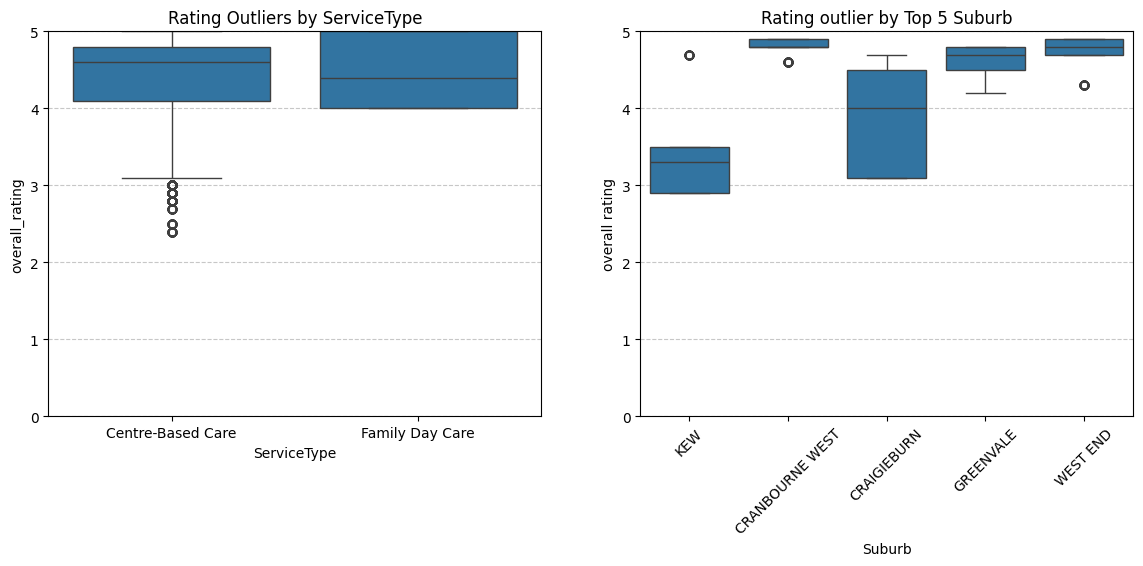

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.boxplot(data=df, x='ServiceType', y='overall_rating', ax=axes[0])
axes[0].set_title("Rating Outliers by ServiceType")
axes[0].set_xlabel("ServiceType")
axes[0].set_ylabel("overall_rating")
axes[0].set_ylim(0, df['overall_rating'].quantile(0.99))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

top5_neigh = df['Suburb'].value_counts().nlargest(5).index
sns.boxplot(data=df[df['Suburb'].isin(top5_neigh)], x='Suburb', y='overall_rating', ax=axes[1])
axes[1].set_title("Rating outlier by Top 5 Suburb")
axes[1].set_xlabel("Suburb")
axes[1].set_ylabel("overall rating")
axes[1].set_ylim(0, df['overall_rating'].quantile(0.99))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

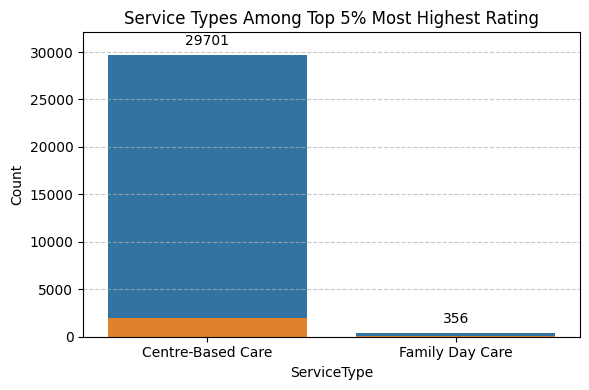

In [15]:
top_5_percent_threshold = df['overall_rating'].quantile(0.95)
top_outliers = df[df['overall_rating'] >= top_5_percent_threshold]


plt.figure(figsize=(6, 4))
order = df['ServiceType'].value_counts().index
ax = sns.countplot(data=df, x='ServiceType', order=order)
max_count = df['ServiceType'].value_counts().max()
ax.set_ylim(0, max_count * 1.08)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5)
sns.countplot(data=top_outliers, x='ServiceType', order=top_outliers['ServiceType'].value_counts().index)
plt.title("Service Types Among Top 5% Most Highest Rating")
plt.xlabel("ServiceType")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
def clean_text(text):
    return re.sub(r"[^a-zA-Z\s]", "", text).lower().strip()

df['cleaned_review'] = df['comments'].apply(clean_text)
df[['comments', 'cleaned_review']].head()

comments  \
0  Sending our daughter to Chrysalis was the best...   
1  Chrysalis is an incredible daycare centre for ...   
2  My child loves attending Chrysalis, often not ...   
3  I have had the pleasure of all 3 of my kids at...   
4  Our daughter has absolutely thrived during her...   

                                      cleaned_review  
0  sending our daughter to chrysalis was the best...  
1  chrysalis is an incredible daycare centre for ...  
2  my child loves attending chrysalis often not w...  
3  i have had the pleasure of all  of my kids att...  
4  our daughter has absolutely thrived during her...

In [19]:
import sys, subprocess, importlib, pkgutil

print("当前 Python:", sys.executable)
print("Python 版本:", sys.version.splitlines()[0])
print("sys.path 前 8 项:", sys.path[:8])

# 查看当前环境是否已经能找到包
try:
    import langdetect
    print("已能 import langdetect，位置:", getattr(langdetect, '__file__', 'unknown'))
except Exception as e:
    print("import 失败，错误：", repr(e))
    print("尝试用当前解释器安装 langdetect...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "langdetect"])
    except subprocess.CalledProcessError as err:
        print("pip 安装失败：", err)
    else:
        # 安装后尝试再次 import
        try:
            importlib.invalidate_caches()
            import langdetect
            print("安装并 import 成功，位置:", getattr(langdetect, '__file__', 'unknown'))
        except Exception as e2:
            print("安装后仍无法 import：", repr(e2))

# 最后打印 pip 所在路径的包信息（确认哪个 pip 被调用）
print("\n使用的 pip 信息：")
subprocess.call([sys.executable, "-m", "pip", "show", "langdetect"])

当前 Python: /opt/miniconda3/envs/notebook-6.4.1/bin/python
Python 版本: 3.9.23 (main, Jun  5 2025, 08:49:36) 
sys.path 前 8 项: ['/opt/miniconda3/envs/notebook-6.4.1/lib/python39.zip', '/opt/miniconda3/envs/notebook-6.4.1/lib/python3.9', '/opt/miniconda3/envs/notebook-6.4.1/lib/python3.9/lib-dynload', '', '/opt/miniconda3/envs/notebook-6.4.1/lib/python3.9/site-packages']
import 失败，错误： ModuleNotFoundError("No module named 'langdetect'")
尝试用当前解释器安装 langdetect...
  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993332 sha256=7ade102445cd67adfeafa5390630f3c848fb6dd7244b08e733d74a400e099ed3
  Stored in directory: /Users/vi/Library/Caches/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
安装并 import 成功，位置: /opt/miniconda3/envs/notebook-6.4.1/lib/python3.9/site-packages/langdetect/__init__.py

使用的 pip 信息：
Name: langdetect
Version: 1.0.9
Summary: Language detection library ported from Google's language-detection.
Home-page: https://github.com/Mimino666/langdetect
Author: Michal Mimino Danilak
Author-email: michal.danilak@gmail.com
License: MIT
Location: /opt/miniconda3/envs/notebook-6.4.1/lib/python3.9/site-packages
Requires: six
Required-by: 


0

In [20]:
!pip install langdetect
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [21]:
# This is accuare solution but time-consuming, if you have a large dataset, or if you want to run in limited time, use the function is_likely_english instead of is_english

# !pip install langdetect
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
def is_likely_english(text):
    # Keep if more than 80% of characters are basic English letters/spaces
    return len(re.findall(r"[a-zA-Z\s]", text)) / max(len(text), 1) > 0.8

# df = df[df['cleaned_review'].apply(is_english)]
df = df[df['cleaned_review'].apply(is_likely_english)]

In [23]:
import sys, subprocess, importlib

print("当前 Python:", sys.executable)
print("Python 版本:", sys.version.splitlines()[0])
print()

# 尝试 import，如果失败则用当前 python 安装
try:
    from nltk.stem import SnowballStemmer
    print("已能 import nltk.SnowballStemmer — 一切正常 ✅")
except Exception as e:
    print("import 失败：", repr(e))
    print("尝试使用当前解释器安装 nltk…")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
    except Exception:
        pass
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    except subprocess.CalledProcessError as err:
        print("pip 安装失败：", err)
    else:
        importlib.invalidate_caches()
        try:
            from nltk.stem import SnowballStemmer
            print("安装并 import 成功 🎉")
        except Exception as e2:
            print("安装后仍 import 失败：", repr(e2))

# 如果你后续需要分词/标点等，可能还需要下载 nltk 资源（可选）
try:
    import nltk
    print("nltk 版本:", nltk.__version__)
    # 下面两行按需解开注释来下载资源（会联网）
    # nltk.download("punkt")
    # nltk.download("stopwords")
except Exception as e:
    print("无法导入 nltk 来显示版本信息：", e)

当前 Python: /opt/miniconda3/envs/notebook-6.4.1/bin/python
Python 版本: 3.9.23 (main, Jun  5 2025, 08:49:36) 

import 失败： ModuleNotFoundError("No module named 'nltk'")
尝试使用当前解释器安装 nltk…
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [nltk]3/4 [nltk]
安装并 import 成功 🎉
nltk 版本: 3.9.1


In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# !pip install nltk
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word not in ENGLISH_STOP_WORDS])

df['stemmed_review'] = df['cleaned_review'].apply(stem_text)
df[['cleaned_review', 'stemmed_review']].head()


cleaned_review  \
0  sending our daughter to chrysalis was the best...   
1  chrysalis is an incredible daycare centre for ...   
2  my child loves attending chrysalis often not w...   
3  i have had the pleasure of all  of my kids att...   
4  our daughter has absolutely thrived during her...   

                                      stemmed_review  
0  send daughter chrysali best decis littl langua...  
1  chrysali incred daycar centr kid uniqu person ...  
2  child love attend chrysali want stop play pick...  
3  pleasur kid attend chrysali like extend famili...  
4  daughter absolut thrive time chrysali staff gr...

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 3), max_features=1000)
X_tfidf = vectorizer.fit_transform(df['stemmed_review'])
X_tfidf.shape

(30041, 1000)

# Q6 1 What can be learned from public Google Reviews about early childhood education service providers? 

In [26]:
from sklearn.cluster import KMeans

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)
df['cluster'] = clusters
feature_names = vectorizer.get_feature_names_out()
top_keywords_per_cluster = []
for i in range(num_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[::-1][:6]
    top_keywords = [feature_names[j] for j in top_indices]
    top_keywords_per_cluster.append(top_keywords)
    print(f"Cluster {i} Keywords:", ", ".join(top_keywords))
for i in range(num_clusters):
    sample = df[df['cluster'] == i].iloc[0]
    print(f"\n--- Sample Review from Cluster {i} ---")
    print(sample['comments'])

Cluster 0 Keywords: child care, child care centr, care centr, best child, best child care, high recommend
Cluster 1 Keywords: high recommend, absolut love, year old, earli learn, staff friend, friend staff
Cluster 2 Keywords: reliabl qualiti, posit respons, reliabl qualiti profession, qualiti profession, respons reliabl, respons reliabl qualiti
Cluster 3 Keywords: staff help, help friend, birthday parti, high recommend, friend staff, great staff

--- Sample Review from Cluster 0 ---
We were very impressed by the premises on our first “show us around” visit earlier this year. The whole building is an architectural designed with passive natural ventilation and oriented to the ultimate fit to the purpose of “child care center” where you can oversee almost every part of the playground but still let the logical people and traffic flow in play due to its unique donut shaped layout. I would suggest parents to experience themselves in the pick up and drop off routine and see how an complete pu

# Q6 2  Do higher average ratings correlate with stronger AEDC outcomes in their respective regions? 

In [35]:
# 在当前 notebook kernel 环境中安装 openpyxl 并尝试读取
import sys, subprocess, importlib

print("当前 Python:", sys.executable)
print("Python 版本:", sys.version.splitlines()[0])

# 1) 安装 openpyxl 到当前解释器
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
except subprocess.CalledProcessError as e:
    print("pip 安装失败：", e)
else:
    print("安装完成，尝试 import openpyxl ...")
    try:
        importlib.invalidate_caches()
        import openpyxl
        print("openpyxl 版本：", openpyxl.__version__)
    except Exception as e:
        print("import openpyxl 失败：", e)

# 2) 重新用 pandas 读一次 Excel（明确指定 engine）
import pandas as pd
aedc = '/Users/Vi/Desktop/usyd/qbus6860/DATA/LGA 2009-21(AEDC).xlsx'
try:
    aedc_raw = pd.read_excel(aedc, sheet_name='LGA One or more', skiprows=5, engine='openpyxl')
    print("读取成功，前 3 行：")
    display(aedc_raw.head(3))
except Exception as e:
    print("读取失败：", e)

当前 Python: /opt/miniconda3/envs/notebook-6.4.1/bin/python
Python 版本: 3.9.23 (main, Jun  5 2025, 08:49:36) 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
安装完成，尝试 import openpyxl ...
openpyxl 版本： 3.1.5
读取成功，前 3 行：


Unnamed: 0             Code               Name   2009   2012   2015   2018  \
0         NaN  New South Wales                NaN  82710  88921  90956  93245   
1         NaN            10050             Albury    587    624    589    626   
2         NaN            10180  Armidale Regional    351    352    309    341   

    2021 2009.1 Unnamed: 9 2012.1 Unnamed: 11 2015.1 Unnamed: 13 2018.1  \
0  90137  17652  21.342038  17722    19.93005  18378   20.205374  18583   
1    649    137  23.339012    156          25    119   20.203735    163   
2    307     91  25.925926    112   31.818182     54   17.475728     84   

  Unnamed: 15 2021.1 Unnamed: 17  
0   19.929219  19067   21.153355  
1   26.038339    158   24.345146  
2   24.633431     85   27.687296

In [36]:
aedc = '/Users/Vi/Desktop/usyd/qbus6860/DATA/LGA 2009-21(AEDC).xlsx'
sheet_name = 'LGA One or more'
aedc_raw = pd.read_excel(aedc,sheet_name = 'LGA One or more',skiprows = 5)
aedc_raw = aedc_raw.drop(aedc_raw.columns[0],axis = 1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[2:8],axis=1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[[3,5,7,9]],axis=1)
aedc_raw = aedc_raw.drop(index=aedc_raw.index[565:576])


remove_state = ['New South Wales','Victoria','Queensland',
               'Western Australia','South Australia',
               'Tasmania','Australian Capital Territory','Northern Territory']
aedc_raw = aedc_raw[~aedc_raw['Code'].astype(str).isin(remove_state)]
               
aedc_raw = aedc_raw.dropna(how='all')
aedc_raw = aedc_raw.reset_index(drop=True)
aedc_raw.columns = ['Code','Name','2009','2012','2015','2018','2021']

aedc_long_onemore =pd.melt(
  aedc_raw,
  id_vars=['Code','Name'],
  value_vars=['2009','2012','2015','2018','2021'],
  var_name='Year',
  value_name='Developmentally vulnerable on one or more')

aedc_long_onemore['Year'] = aedc_long_onemore['Year'].astype(int)
aedc_long_onemore = aedc_long_onemore.reset_index(drop=True)
aedc_long_onemore

Code                Name  Year  \
0     10050              Albury  2009   
1     10180   Armidale Regional  2009   
2     10250             Ballina  2009   
3     10300           Balranald  2009   
4     10470   Bathurst Regional  2009   
...     ...                 ...   ...   
2735  74560              Wagait  2021   
2736  74660         West Arnhem  2021   
2737  74680           West Daly  2021   
2738  79399   Unincorporated NT  2021   
2739  89399  Unincorporated ACT  2021   

     Developmentally vulnerable on one or more  
0                                    23.339012  
1                                    25.925926  
2                                      24.8394  
3                                    16.129032  
4                                    23.142251  
...                                        ...  
2735                                         *  
2736                                         *  
2737                                 71.186441  
2738                                     23.75  
2739                                 26.698062  

[2740 rows x 4 columns]

In [39]:
aedc = '/Users/Vi/Desktop/usyd/qbus6860/DATA/LGA 2009-21(AEDC).xlsx'
sheet_name = 'LGA Two or more'
aedc_raw = pd.read_excel(aedc,sheet_name = 'LGA Two or more',skiprows = 5)
aedc_raw = aedc_raw.drop(aedc_raw.columns[0],axis = 1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[2:8],axis=1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[[3,5,7,9]],axis=1)
aedc_raw = aedc_raw.drop(index=aedc_raw.index[565:576])


remove_state = ['New South Wales','Victoria','Queensland',
               'Western Australia','South Australia',
               'Tasmania','Australian Capital Territory','Northern Territory']
aedc_raw = aedc_raw[~aedc_raw['Code'].astype(str).isin(remove_state)]
              
aedc_raw = aedc_raw.dropna(how='all')
aedc_raw = aedc_raw.reset_index(drop=True)

aedc_raw.columns = ['Code','Name','2009','2012','2015','2018','2021']

aedc_long_twomore =pd.melt(
  aedc_raw,
  id_vars=['Code','Name'],
  value_vars=['2009','2012','2015','2018','2021'],
  var_name='Year',
  value_name='Developmentally vulnerable on two or more')

aedc_long_twomore['Year'] = aedc_long_twomore['Year'].astype(int)
aedc_long_twomore = aedc_long_twomore.reset_index(drop=True)
aedc_long_twomore

Code                Name  Year  \
0     10050              Albury  2009   
1     10180   Armidale Regional  2009   
2     10250             Ballina  2009   
3     10300           Balranald  2009   
4     10470   Bathurst Regional  2009   
...     ...                 ...   ...   
2735  74560              Wagait  2021   
2736  74660         West Arnhem  2021   
2737  74680           West Daly  2021   
2738  79399   Unincorporated NT  2021   
2739  89399  Unincorporated ACT  2021   

     Developmentally vulnerable on two or more  
0                                    12.776831  
1                                    14.814815  
2                                      10.8742  
3                                     9.677419  
4                                    11.677282  
...                                        ...  
2735                                         *  
2736                                         *  
2737                                 52.542373  
2738                                        10  
2739                                 13.286334  

[2740 rows x 4 columns]

In [40]:
aedc_merged = pd.merge(aedc_long_onemore,aedc_long_twomore,on=['Code','Name','Year'],how='outer')
aedc_merged

Code            Name  Year Developmentally vulnerable on one or more  \
0     10050          Albury  2009                                 23.339012   
1     10050          Albury  2012                                        25   
2     10050          Albury  2015                                 20.203735   
3     10050          Albury  2018                                 26.038339   
4     10050          Albury  2021                                 24.345146   
...     ...             ...   ...                                       ...   
2735  99999  Norfolk Island  2009                                         *   
2736  99999  Norfolk Island  2012                                         *   
2737  99999  Norfolk Island  2015                                         *   
2738  99999  Norfolk Island  2018                                         *   
2739  99999  Norfolk Island  2021                                        25   

     Developmentally vulnerable on two or more  
0                                    12.776831  
1                                    12.179487  
2                                      9.98308  
3                                    15.015974  
4                                    13.734568  
...                                        ...  
2735                                         *  
2736                                         *  
2737                                         *  
2738                                         *  
2739                                      12.5  

[2740 rows x 5 columns]

In [41]:
aedc_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Code                                       2740 non-null   object
 1   Name                                       2740 non-null   object
 2   Year                                       2740 non-null   int64 
 3   Developmentally vulnerable on one or more  2740 non-null   object
 4   Developmentally vulnerable on two or more  2740 non-null   object
dtypes: int64(1), object(4)
memory usage: 107.2+ KB


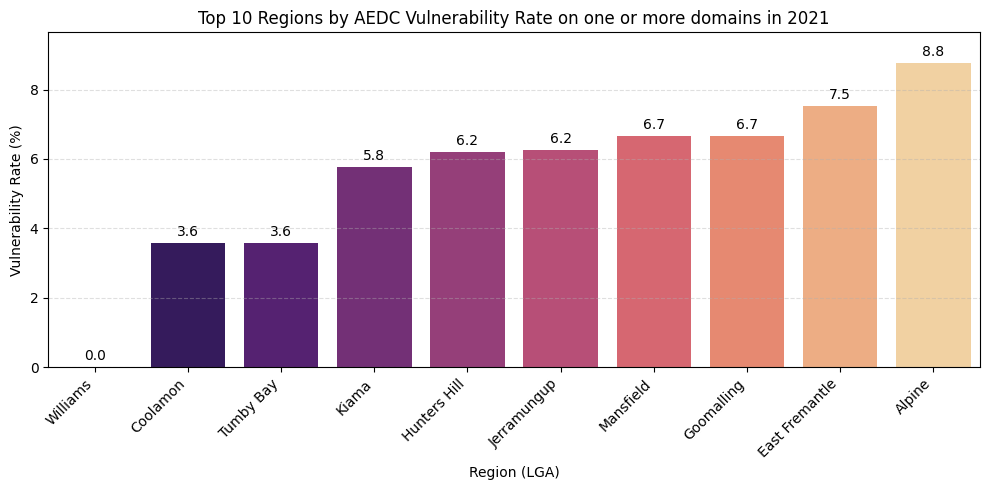

In [42]:
year = 2021
df_vuln = aedc_merged[aedc_merged['Year'] == year].copy()
df_vuln['vuln_rate'] = pd.to_numeric(df_vuln['Developmentally vulnerable on one or more'], errors='coerce')
df_vuln = df_vuln.dropna(subset=['vuln_rate'])

df_top10 = df_vuln.sort_values(by='vuln_rate', ascending=True).head(10)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_top10,
    x='Name',
    y='vuln_rate',
    palette='magma'
)

ax.set_title(f"Top 10 Regions by AEDC Vulnerability Rate on one or more domains in {year}")
ax.set_xlabel("Region (LGA)")
ax.set_ylabel("Vulnerability Rate (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, df_top10['vuln_rate'].max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.4)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

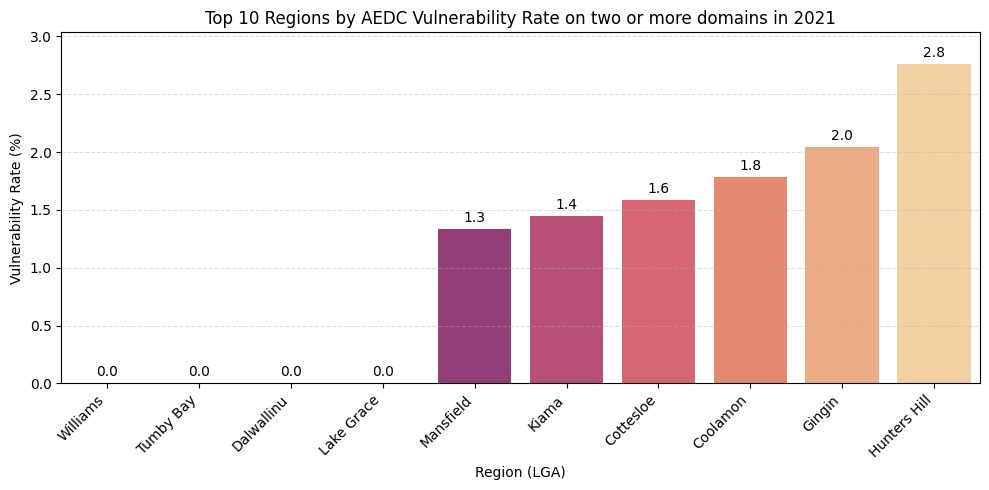

In [43]:
year = 2021
df_vuln = aedc_merged[aedc_merged['Year'] == year].copy()
df_vuln['vuln_rate'] = pd.to_numeric(df_vuln['Developmentally vulnerable on two or more'], errors='coerce')
df_vuln = df_vuln.dropna(subset=['vuln_rate'])

df_top10 = df_vuln.sort_values(by='vuln_rate', ascending=True).head(10)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_top10,
    x='Name',
    y='vuln_rate',
    palette='magma'
)

ax.set_title(f"Top 10 Regions by AEDC Vulnerability Rate on two or more domains in {year}")
ax.set_xlabel("Region (LGA)")
ax.set_ylabel("Vulnerability Rate (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, df_top10['vuln_rate'].max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.4)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

In [44]:
rating_bins = pd.qcut(df['overall_rating'], q=5, labels=['Significant Improvement Required', 'Working Towards NQS', 'Meeting NQS', 'Excellent NQS', 'Excellent'])
df['rating_category'] = rating_bins

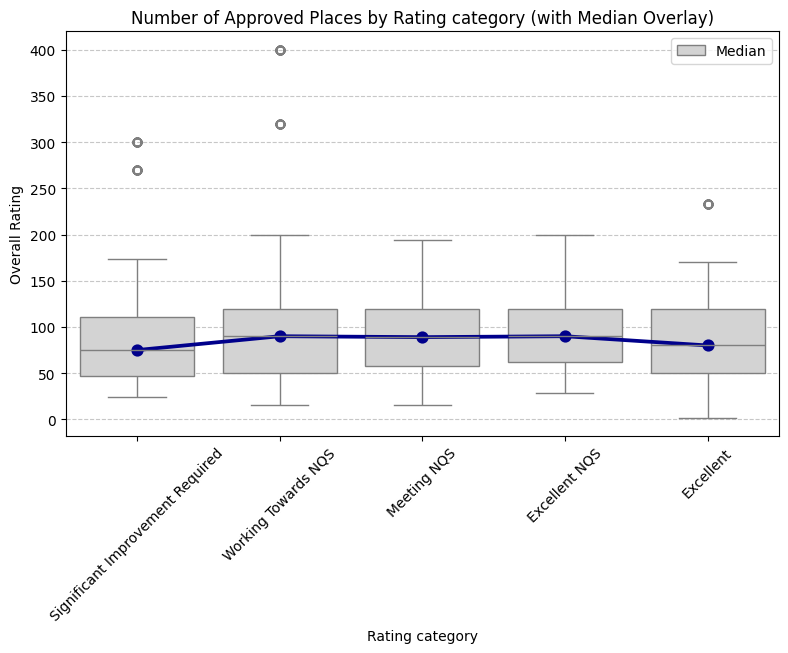

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='rating_category', y='NumberOfApprovedPlaces', color='lightgray')

medians = df.groupby('rating_category')['NumberOfApprovedPlaces'].median().reindex(['Significant Improvement Required', 'Working Towards NQS', 'Meeting NQS', 'Excellent NQS', 'Excellent'])

sns.pointplot(x=medians.index, y=medians.values, color='darkblue', label='Median', linestyles='-', markers='o')

plt.title("Number of Approved Places by Rating category (with Median Overlay)")
plt.xlabel("Rating category")
plt.ylabel("Overall Rating")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(["Median"])
plt.show()

In [46]:
df['suburb_clean'] = df['Suburb'].str.lower().str.strip()
aedc_merged['Name_clean'] = aedc_merged['Name'].str.lower().str.strip()


subs_df   = set(df['suburb_clean'].unique())
subs_aedc = set(aedc_merged['Name_clean'].unique())
common    = subs_df & subs_aedc

print(f"Have {len(common)} common Suburb：", common)

Have 30 common Suburb： {'coffs harbour', 'bundaberg', 'penrith', 'richmond', 'melton', 'ryde', 'joondalup', 'cessnock', 'vincent', 'mosman park', 'burnside', 'burwood', 'mansfield', 'busselton', 'wanneroo', 'toowoomba', 'north sydney', 'devonport', 'fairfield', 'singleton', 'hornsby', 'armadale', 'parramatta', 'sydney', 'croydon', 'blacktown', 'wangaratta', 'maribyrnong', 'adelaide', 'salisbury'}


In [47]:
df_common   = df[df['suburb_clean'].isin(common)].copy()
aedc_common = aedc_merged[aedc_merged['Name_clean'].isin(common)].copy()
df_common

ServiceName  \
0              Chrysalis Early Learning Centre   
1              Chrysalis Early Learning Centre   
2              Chrysalis Early Learning Centre   
3              Chrysalis Early Learning Centre   
4              Chrysalis Early Learning Centre   
...                                        ...   
29871  Two Peas In A Pod Early Learning Centre   
29872  Two Peas In A Pod Early Learning Centre   
29873  Two Peas In A Pod Early Learning Centre   
29874  Two Peas In A Pod Early Learning Centre   
29875  Two Peas In A Pod Early Learning Centre   

                                                comments  \
0      Sending our daughter to Chrysalis was the best...   
1      Chrysalis is an incredible daycare centre for ...   
2      My child loves attending Chrysalis, often not ...   
3      I have had the pleasure of all 3 of my kids at...   
4      Our daughter has absolutely thrived during her...   
...                                                  ...   
29871                                                nan   
29872                                                nan   
29873                                                nan   
29874                                                nan   
29875                                                nan   

                        TitleShownOnGoogleMaps  overall_rating  OverallRating  \
0              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
1              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
2              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
3              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
4              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
...                                        ...             ...            ...   
29871  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
29872  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
29873  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
29874  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
29875  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   

             ServiceType     Suburb State  NumberOfApprovedPlaces  \
0      Centre-Based Care  BUNDABERG   QLD                   100.0   
1      Centre-Based Care  BUNDABERG   QLD                   100.0   
2      Centre-Based Care  BUNDABERG   QLD                   100.0   
3      Centre-Based Care  BUNDABERG   QLD                   100.0   
4      Centre-Based Care  BUNDABERG   QLD                   100.0   
...                  ...        ...   ...                     ...   
29871  Centre-Based Care  BLACKTOWN   NSW                    39.0   
29872  Centre-Based Care  BLACKTOWN   NSW                    39.0   
29873  Centre-Based Care  BLACKTOWN   NSW                    39.0   
29874  Centre-Based Care  BLACKTOWN   NSW                    39.0   
29875  Centre-Based Care  BLACKTOWN   NSW                    39.0   

                                          cleaned_review  \
0      sending our daughter to chrysalis was the best...   
1      chrysalis is an incredible daycare centre for ...   
2      my child loves attending chrysalis often not w...   
3      i have had the pleasure of all  of my kids att...   
4      our daughter has absolutely thrived during her...   
...                                                  ...   
29871                                                nan   
29872                                                nan   
29873                                                nan   
29874                                                nan   
29875                                                nan   

                                          stemmed_review  cluster  \
0      send daughter chrysali best decis littl langua...        1   
1      chrysali incred daycar centr kid uniqu person

In [48]:
google_aedc = pd.merge(df_common,
                      aedc_common[['Name_clean','Developmentally vulnerable on one or more',
                                   'Developmentally vulnerable on two or more']],
                      left_on = 'suburb_clean',
                      right_on = 'Name_clean',
                      how = 'left')
google_aedc

ServiceName  \
0              Chrysalis Early Learning Centre   
1              Chrysalis Early Learning Centre   
2              Chrysalis Early Learning Centre   
3              Chrysalis Early Learning Centre   
4              Chrysalis Early Learning Centre   
...                                        ...   
12180  Two Peas In A Pod Early Learning Centre   
12181  Two Peas In A Pod Early Learning Centre   
12182  Two Peas In A Pod Early Learning Centre   
12183  Two Peas In A Pod Early Learning Centre   
12184  Two Peas In A Pod Early Learning Centre   

                                                comments  \
0      Sending our daughter to Chrysalis was the best...   
1      Sending our daughter to Chrysalis was the best...   
2      Sending our daughter to Chrysalis was the best...   
3      Sending our daughter to Chrysalis was the best...   
4      Sending our daughter to Chrysalis was the best...   
...                                                  ...   
12180                                                nan   
12181                                                nan   
12182                                                nan   
12183                                                nan   
12184                                                nan   

                        TitleShownOnGoogleMaps  overall_rating  OverallRating  \
0              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
1              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
2              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
3              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
4              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
...                                        ...             ...            ...   
12180  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
12181  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
12182  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
12183  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
12184  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   

             ServiceType     Suburb State  NumberOfApprovedPlaces  \
0      Centre-Based Care  BUNDABERG   QLD                   100.0   
1      Centre-Based Care  BUNDABERG   QLD                   100.0   
2      Centre-Based Care  BUNDABERG   QLD                   100.0   
3      Centre-Based Care  BUNDABERG   QLD                   100.0   
4      Centre-Based Care  BUNDABERG   QLD                   100.0   
...                  ...        ...   ...                     ...   
12180  Centre-Based Care  BLACKTOWN   NSW                    39.0   
12181  Centre-Based Care  BLACKTOWN   NSW                    39.0   
12182  Centre-Based Care  BLACKTOWN   NSW                    39.0   
12183  Centre-Based Care  BLACKTOWN   NSW                    39.0   
12184  Centre-Based Care  BLACKTOWN   NSW                    39.0   

                                          cleaned_review  \
0      sending our daughter to chrysalis was the best...   
1      sending our daughter to chrysalis was the best...   
2      sending our daughter to chrysalis was the best...   
3      sending our daughter to chrysalis was the best...   
4      sending our daughter to chrysalis was the best...   
...                                                  ...   
12180                                                nan   
12181                                                nan   
12182                                                nan   
12183                                                nan   
12184                                                nan   

                                          stemmed_review  cluster  \
0      send daughter chrysali best decis littl langua...        1   
1      send daughter chrysali best decis littl langu

In [49]:
google_aedc['Developmentally vulnerable on one or more'] = pd.to_numeric(google_aedc['Developmentally vulnerable on one or more'], errors='coerce')
google_aedc['Developmentally vulnerable on two or more'] = pd.to_numeric(google_aedc['Developmentally vulnerable on two or more'],errors = 'coerce')

In [50]:
mean_by_suburb = google_aedc.groupby("Suburb")["overall_rating"].mean().dropna()

sorted_suburbs = mean_by_suburb.sort_values(ascending=False).index.tolist()
#CROYDON is * in excel
top10_suburbs = []
for suburb in sorted_suburbs:
    if suburb == "CROYDON":
        continue
    top10_suburbs.append(suburb)
    if len(top10_suburbs) == 10:
        break

top10_suburbs

['WANNEROO',
 'FAIRFIELD',
 'WANGARATTA',
 'VINCENT',
 'TOOWOOMBA',
 'BUSSELTON',
 'JOONDALUP',
 'BURWOOD',
 'SYDNEY',
 'MARIBYRNONG']

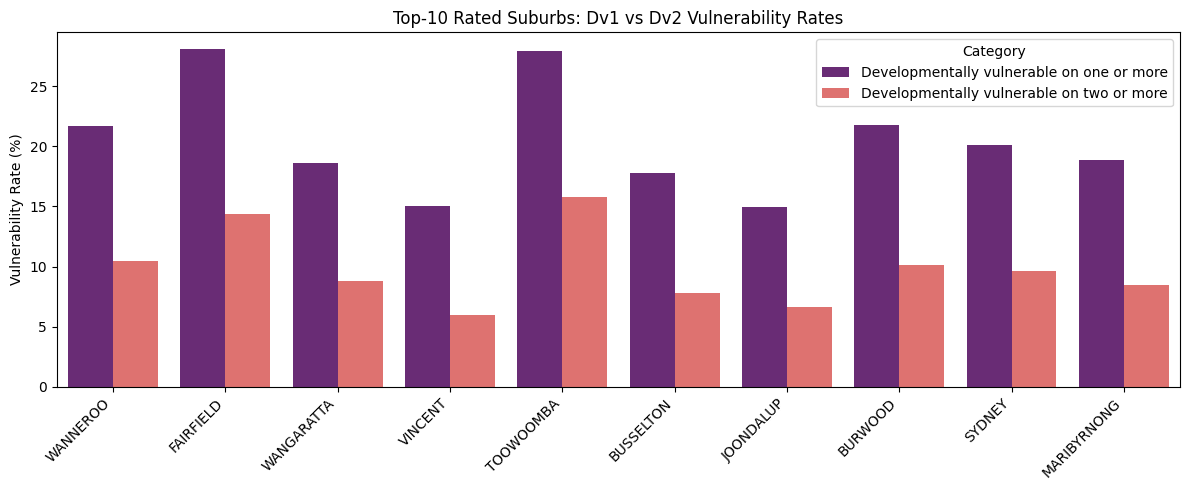

In [51]:
vuln_both = (
    google_aedc[google_aedc['Suburb'].isin(top10_suburbs)]
    .groupby('Suburb')[[
        'Developmentally vulnerable on one or more',
        'Developmentally vulnerable on two or more'
    ]]
    .mean()
    .reindex(top10_suburbs)
    .reset_index()
)

vuln_melt = vuln_both.melt(
    id_vars='Suburb',
    value_vars=[
        'Developmentally vulnerable on one or more',
        'Developmentally vulnerable on two or more'
    ],
    var_name='DV_Category',
    value_name='Rate'
)

plt.figure(figsize=(12,5))
sns.barplot(
    data=vuln_melt,
    x='Suburb',
    y='Rate',
    hue='DV_Category',
    palette='magma'
)
plt.xticks(rotation=45, ha='right')
plt.title("Top-10 Rated Suburbs: Dv1 vs Dv2 Vulnerability Rates")
plt.ylabel("Vulnerability Rate (%)")
plt.xlabel("")
plt.legend(title="Category", loc='upper right')
plt.tight_layout()
plt.show()

# Q3

In [52]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_tfidf.sum(axis=0)
top_indices = np.argsort(tfidf_sum.A1)[::-1][:100]
top_keywords = np.array(feature_names)[top_indices]

keyword_vectorizer = TfidfVectorizer()
keyword_vectors = keyword_vectorizer.fit_transform(top_keywords)

n_clusters = 5
kmeans_kw = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans_kw.fit_predict(keyword_vectors.toarray())

grouped_keywords = defaultdict(list)
for word, label in zip(top_keywords, labels):
    grouped_keywords[label].append(word)
    
for cluster_id, words in grouped_keywords.items():
     print(f"Cluster {cluster_id}: {', '.join(words)}")

Cluster 1: high recommend, absolut love, year old, child care, qualiti profession, earli learn, daughter love, great place, month old, recommend centr, kid love, profession valu, great school, day care, son love, qualiti profession valu, good school, childcar centr, look forward, love care, care kid, feel like, centr manag, come home, genuin care, love centr, love school, love place, definit recommend, custom servic, make feel, amaz centr, stori hous, warm welcom, great centr, make sure, best school, high recommend centr, love teacher, learn centr, send child, send kid, feel comfort, care centr, primari school, year ago, play area, nurtur environ, care love, feel welcom, great experi, care child, like famili, absolut amaz, centr year, earli learn centr, place kid, school teacher, care attent, daughter start, care provid, centr clean, realli enjoy, great facil, realli care, feel safe
Cluster 4: staff friend, friend staff, love educ, care educ, educ care, friend help, friend care, educ a

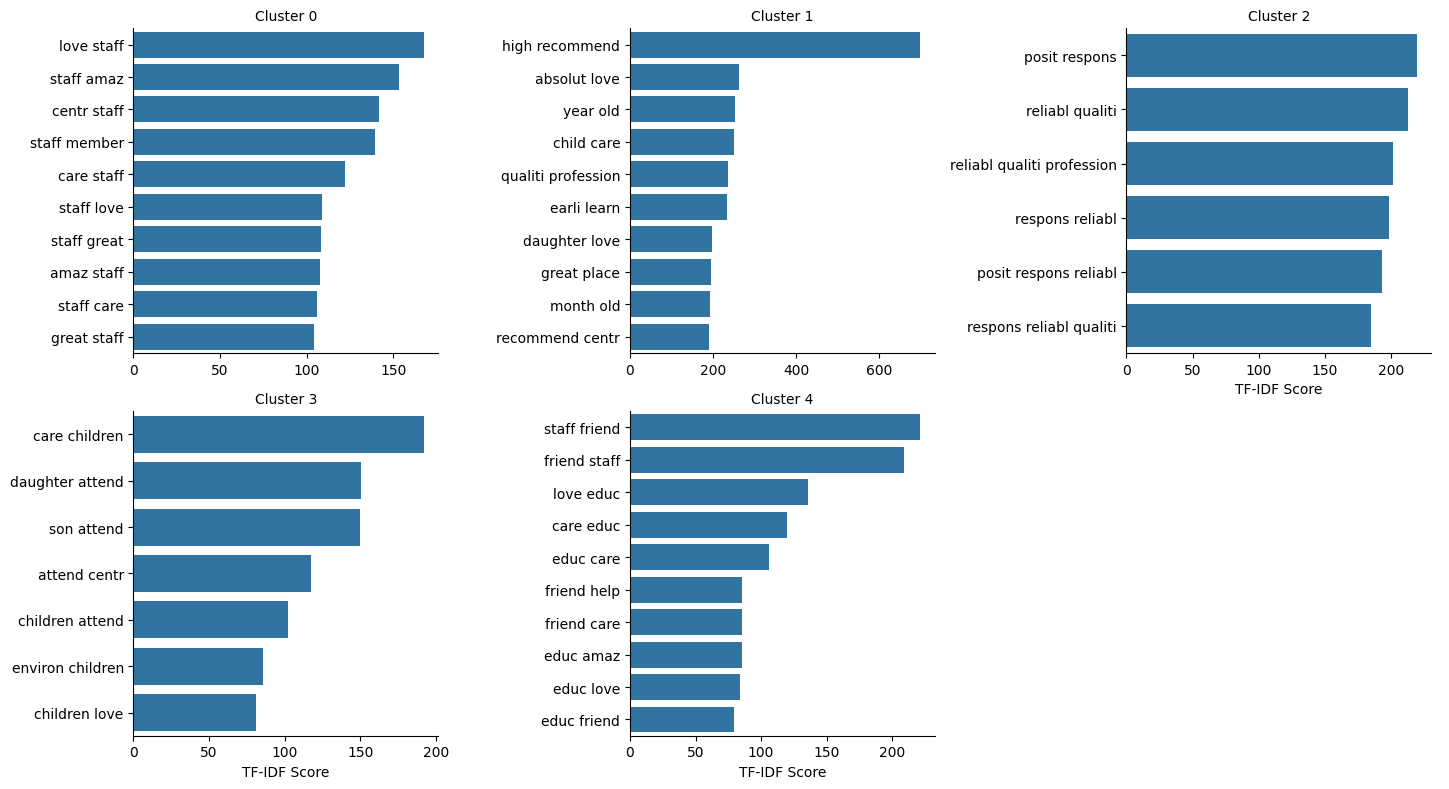

In [53]:
scores = tfidf_sum.A1  

word2score = { feature_names[i]: scores[i]
               for i in range(len(feature_names)) }

scored_grouped_keywords = {
    cid: [(w, word2score.get(w, 0.0)) for w in words]
    for cid, words in grouped_keywords.items()
}



rows = []
for cluster_id, words in scored_grouped_keywords.items():  
    for word, score in words[:10]:
        rows.append({"cluster": cluster_id, "keyword": word, "score": score})
df_plot = pd.DataFrame(rows)

g = sns.catplot(
    data=df_plot,
    x="score", y="keyword",
    col="cluster", col_wrap=3,   
    kind="bar",
    sharex=False, sharey=False,
    height=4, aspect=1.2
)
g.set_titles("Cluster {col_name}")
g.set_axis_labels("TF-IDF Score", "")
plt.tight_layout()
plt.show()

# Q4 Are there noticeable patterns in Google reviews in areas with high developmental vulnerability?

In [54]:
df['Suburb_clean'] = df['Suburb'].str.strip().str.lower()

aedc_merged['Name_clean'] = (
    aedc_merged['Name']
    .astype(str)
    .str.strip()
    .str.lower()
 
)

df_aedc_merge = pd.merge(
    df,
    aedc_merged[
        ['Name_clean', 'Developmentally vulnerable on one or more','Developmentally vulnerable on two or more']
    ],
    left_on = 'Suburb_clean',
    right_on = 'Name_clean',
    how     = 'left'
)
df_aedc_merge.dropna(subset=['Developmentally vulnerable on two or more'], inplace=True)
df_aedc_merge

ServiceName  \
0              Chrysalis Early Learning Centre   
1              Chrysalis Early Learning Centre   
2              Chrysalis Early Learning Centre   
3              Chrysalis Early Learning Centre   
4              Chrysalis Early Learning Centre   
...                                        ...   
39603  Two Peas In A Pod Early Learning Centre   
39604  Two Peas In A Pod Early Learning Centre   
39605  Two Peas In A Pod Early Learning Centre   
39606  Two Peas In A Pod Early Learning Centre   
39607  Two Peas In A Pod Early Learning Centre   

                                                comments  \
0      Sending our daughter to Chrysalis was the best...   
1      Sending our daughter to Chrysalis was the best...   
2      Sending our daughter to Chrysalis was the best...   
3      Sending our daughter to Chrysalis was the best...   
4      Sending our daughter to Chrysalis was the best...   
...                                                  ...   
39603                                                nan   
39604                                                nan   
39605                                                nan   
39606                                                nan   
39607                                                nan   

                        TitleShownOnGoogleMaps  overall_rating  OverallRating  \
0              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
1              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
2              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
3              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
4              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
...                                        ...             ...            ...   
39603  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39604  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39605  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39606  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39607  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   

             ServiceType     Suburb State  NumberOfApprovedPlaces  \
0      Centre-Based Care  BUNDABERG   QLD                   100.0   
1      Centre-Based Care  BUNDABERG   QLD                   100.0   
2      Centre-Based Care  BUNDABERG   QLD                   100.0   
3      Centre-Based Care  BUNDABERG   QLD                   100.0   
4      Centre-Based Care  BUNDABERG   QLD                   100.0   
...                  ...        ...   ...                     ...   
39603  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39604  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39605  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39606  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39607  Centre-Based Care  BLACKTOWN   NSW                    39.0   

                                          cleaned_review  \
0      sending our daughter to chrysalis was the best...   
1      sending our daughter to chrysalis was the best...   
2      sending our daughter to chrysalis was the best...   
3      sending our daughter to chrysalis was the best...   
4      sending our daughter to chrysalis was the best...   
...                                                  ...   
39603                                                nan   
39604                                                nan   
39605                                                nan   
39606                                                nan   
39607                                                nan   

                                          stemmed_review  cluster  \
0      send daughter chrysali best decis littl langua...        1   
1      send daughter chrysali best decis littl langu

In [55]:
df_aedc_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12185 entries, 0 to 39607
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   ServiceName                                12185 non-null  object  
 1   comments                                   12185 non-null  object  
 2   TitleShownOnGoogleMaps                     12185 non-null  object  
 3   overall_rating                             12185 non-null  float64 
 4   OverallRating                              11280 non-null  object  
 5   ServiceType                                12185 non-null  object  
 6   Suburb                                     12185 non-null  object  
 7   State                                      12185 non-null  object  
 8   NumberOfApprovedPlaces                     12185 non-null  float64 
 9   cleaned_review                             12185 non-null  object  
 10  stemmed_review 

In [56]:
df_aedc_merge['DV1_rate_num'] = pd.to_numeric(
    df_aedc_merge['Developmentally vulnerable on one or more'],
    errors='coerce'
)
high_vuln_dv1 = df_aedc_merge[df_aedc_merge['DV1_rate_num'] > 30]
high_vuln_onemore = high_vuln_dv1['Suburb'].unique()
high_vuln_onemore

array(['BUNDABERG', 'RICHMOND', 'ARMADALE', 'TOOWOOMBA', 'ADELAIDE',
       'SALISBURY'], dtype=object)

In [57]:
df_aedc_merge['high_vuln_onemore'] = df_aedc_merge['Suburb'].isin(high_vuln_onemore)
df_aedc_merge

ServiceName  \
0              Chrysalis Early Learning Centre   
1              Chrysalis Early Learning Centre   
2              Chrysalis Early Learning Centre   
3              Chrysalis Early Learning Centre   
4              Chrysalis Early Learning Centre   
...                                        ...   
39603  Two Peas In A Pod Early Learning Centre   
39604  Two Peas In A Pod Early Learning Centre   
39605  Two Peas In A Pod Early Learning Centre   
39606  Two Peas In A Pod Early Learning Centre   
39607  Two Peas In A Pod Early Learning Centre   

                                                comments  \
0      Sending our daughter to Chrysalis was the best...   
1      Sending our daughter to Chrysalis was the best...   
2      Sending our daughter to Chrysalis was the best...   
3      Sending our daughter to Chrysalis was the best...   
4      Sending our daughter to Chrysalis was the best...   
...                                                  ...   
39603                                                nan   
39604                                                nan   
39605                                                nan   
39606                                                nan   
39607                                                nan   

                        TitleShownOnGoogleMaps  overall_rating  OverallRating  \
0              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
1              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
2              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
3              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
4              Chrysalis Early Learning Centre             4.8  Exceeding NQS   
...                                        ...             ...            ...   
39603  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39604  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39605  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39606  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   
39607  Two Peas In A Pod Early Learning Centre             4.1    Meeting NQS   

             ServiceType     Suburb State  NumberOfApprovedPlaces  \
0      Centre-Based Care  BUNDABERG   QLD                   100.0   
1      Centre-Based Care  BUNDABERG   QLD                   100.0   
2      Centre-Based Care  BUNDABERG   QLD                   100.0   
3      Centre-Based Care  BUNDABERG   QLD                   100.0   
4      Centre-Based Care  BUNDABERG   QLD                   100.0   
...                  ...        ...   ...                     ...   
39603  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39604  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39605  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39606  Centre-Based Care  BLACKTOWN   NSW                    39.0   
39607  Centre-Based Care  BLACKTOWN   NSW                    39.0   

                                          cleaned_review  \
0      sending our daughter to chrysalis was the best...   
1      sending our daughter to chrysalis was the best...   
2      sending our daughter to chrysalis was the best...   
3      sending our daughter to chrysalis was the best...   
4      sending our daughter to chrysalis was the best...   
...                                                  ...   
39603                                                nan   
39604                                                nan   
39605                                                nan   
39606                                                nan   
39607                                                nan   

                                          stemmed_review  cluster  \
0      send daughter chrysali best decis littl langua...        1   
1      send daughter chrysali best decis littl langu

In [58]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 3), max_features=1000)
X_tfidf_vuln = vectorizer.fit_transform(df_aedc_merge['stemmed_review'])
X_tfidf_vuln.shape

(12185, 1000)

In [59]:
from sklearn.decomposition import PCA

X_array = X_tfidf_vuln.toarray()

pca_model = PCA(n_components=50, random_state=42)
X_pca = pca_model.fit_transform(X_array)

In [61]:
import sys, subprocess, importlib
print("当前 Python:", sys.executable)
print("Python 版本:", sys.version.splitlines()[0])

# 安装 plotly 到当前解释器
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
except subprocess.CalledProcessError as e:
    print("pip 安装失败：", e)
else:
    importlib.invalidate_caches()
    try:
        import plotly, plotly.express as px
        print("plotly 安装并导入成功，版本：", plotly.__version__)
        # 简单示例（用随机点代替你的 coords）
        import numpy as np
        df = {"x": np.random.randn(100), "y": np.random.randn(100)}
        fig = px.scatter(df, x="x", y="y", title="Plotly 测试散点图")
        fig.show()
    except Exception as ex:
        print("导入或绘图时报错：", ex)
        print("如果在 JupyterLab 中，请确认 JupyterLab 版本 >=3，或安装 lab 扩展。")

当前 Python: /opt/miniconda3/envs/notebook-6.4.1/bin/python
Python 版本: 3.9.23 (main, Jun  5 2025, 08:49:36) 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 10.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]
plotly 安装并导入成功，版本： 6.3.0


In [62]:
import textwrap

def segment_comment(comment, width=50):
    if not isinstance(comment, str) or comment.strip() == "":
        return comment
    lines = textwrap.wrap(comment, width=width)
    return "<br>".join(lines)

df_aedc_merge['comments'] = df_aedc_merge['comments'].apply(lambda c: segment_comment(c, width=50))
import plotly.io as pio

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
coords = tsne.fit_transform(X_array)
df_aedc_merge['tsne_x'] = coords[:, 0]
df_aedc_merge['tsne_y'] = coords[:, 1]

import plotly.express as px

fig = px.scatter(
    df_aedc_merge, x='tsne_x', y='tsne_y', color='high_vuln_onemore',
    title="t-SNE Visualization of Rating Colored by high developmental vulnerability ",
    hover_data=['comments','Suburb','overall_rating'],
    width=700, height=500
)

fig.update_layout(
    legend_title_text='High vulnerable',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5,
        title_font=dict(size=10),
        font=dict(size=9),
        bgcolor='rgba(255,255,255,0.5)',
        traceorder='normal'
    )
)

fig.show()